In [47]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import pathlib
import pandas as pd
import pydot
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

In [48]:
train_dir = './fer2013/train/'
test_dir = './fer2013/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_={}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)
    

       angry  fear  surprise   sad  neutral  happy
train   3995  4097      3171  4830     4965   7215
      angry  fear  surprise   sad  neutral  happy
test    958  1024       831  1247     1233   1774


### Plot of number of images in train set

<AxesSubplot:>

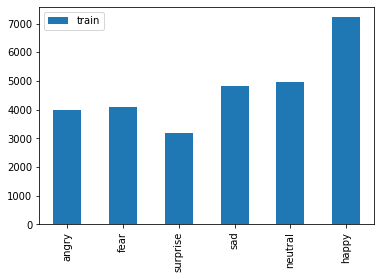

In [49]:
train_count.transpose().plot(kind='bar')

(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)


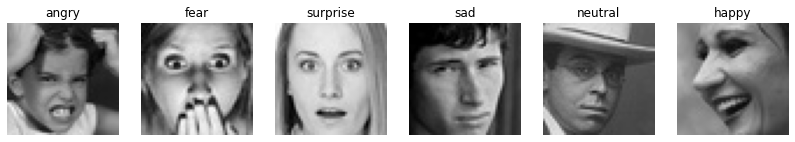

In [50]:
fig, axs = plt.subplots(1, 6, figsize=(14, 22))
i = 0
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression + '/' + os.listdir(train_dir + expression)[1]))
    axs[i].imshow(img)
    axs[i].set_title(expression)
    axs[i].axis('off')
    print(np.array(img).shape) ## (48, 48, 3)
    i += 1
plt.show() 


### Creating Training and test sets

ImageDataGenerator를 만들 시 rescale, shear_range, zoom_range, horizontal_flip를 설정해줌으로써 해당 데이터의 전처리를 어떻게 할지를 정해준다.

In [56]:
np.random.seed(42)
train_generator = ImageDataGenerator(rescale=1./255, 
                                     validation_split=0.2)  
test_generator = ImageDataGenerator(rescale=1./255)

train_dir = './fer2013/train'
test_dir = './fer2013/test'


train_set = train_generator.flow_from_directory(train_dir,
                                                 batch_size=64,
                                                 shuffle=True,
                                                 target_size=(48, 48), 
                                                 subset="training",
                                                 color_mode='grayscale', 
                                                 class_mode='categorical')

validation_set = train_generator.flow_from_directory(train_dir,
                                                 batch_size=64,
                                                 shuffle=True,
                                                 target_size=(48, 48), 
                                                 subset="validation",
                                                 color_mode='grayscale',
                                                 class_mode='categorical')

test_set = test_generator.flow_from_directory(test_dir,
                                              batch_size=64,
                                              shuffle=True,
                                              target_size=(48, 48),
                                              color_mode='grayscale',
                                              class_mode='categorical')


Found 22619 images belonging to 6 classes.
Found 5654 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


In [57]:
print(train_set)
print(train_set.classes)
print(train_set.class_indices)

[0 0 0 ... 5 5 5]
{'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}


In [58]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same', input_shape=(48, 48, 1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(2))
model.add(keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(2))
model.add(keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(2))
model.add(keras.layers.Conv2D(256, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1000, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(6, activation='softmax'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_20 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_21 (Batc (None, 24, 24, 128)       512       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 12, 12, 128)     

In [54]:
keras.utils.plot_model(model, show_shapes=True, to_file='emotionRecognition_CNN.png', dpi=300)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [59]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('er-best-cnn-model.h5')
earlystopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_set, epochs=60, validation_data= validation_set, 
                   callbacks=[checkpoint_cb, earlystopping_cb])

Epoch 1/60
354/354 [==============================] - 10s 26ms/step - loss: 1.9681 - accuracy: 0.2380 - val_loss: 1.7464 - val_accuracy: 0.2552
Epoch 2/60
354/354 [==============================] - 9s 26ms/step - loss: 1.6678 - accuracy: 0.2863 - val_loss: 1.5923 - val_accuracy: 0.3214
Epoch 3/60
354/354 [==============================] - 9s 27ms/step - loss: 1.5676 - accuracy: 0.3480 - val_loss: 1.6141 - val_accuracy: 0.3479
Epoch 4/60
354/354 [==============================] - 9s 27ms/step - loss: 1.4546 - accuracy: 0.4060 - val_loss: 1.3717 - val_accuracy: 0.4466
Epoch 5/60
354/354 [==============================] - 9s 26ms/step - loss: 1.3678 - accuracy: 0.4408 - val_loss: 1.5732 - val_accuracy: 0.3845
Epoch 6/60
354/354 [==============================] - 10s 27ms/step - loss: 1.3038 - accuracy: 0.4674 - val_loss: 1.5171 - val_accuracy: 0.3750
Epoch 7/60
354/354 [==============================] - 9s 27ms/step - loss: 1.2260 - accuracy: 0.5038 - val_loss: 1.3009 - val_accuracy: 0.49

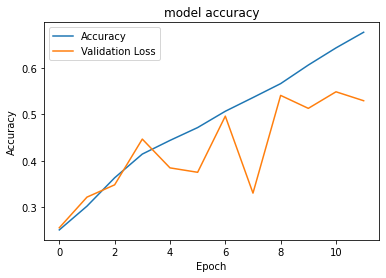

In [60]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Loss"])
plt.show()